Welcome to the National Water Model (NWM) Sandbox! This Jupyter Notebook contains Python functions that will allow you to explore NWM forecasts for any river segment covered by the NWM. Execute each cell in the order that they appear and read the comments and notes that are included along the way.

The next cell installs or imports all of the modules or packages that will be used in this notebook.

In [21]:
from datetime import date
import os
import requests
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import numpy as np

#Set-up inline plots using matplotlib
%matplotlib inline

The next code cell defines all of the functions that are used in the notebook. Short descriptions are provided next to each function. Try to understand how they work by reading through the code.

In [2]:
#This function builds a file name for a specific forecast from the NOAA NWM http file delivery web site like this one:
#https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210320/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  #ForecastStartDate = date.today.strftime('%Y%m%d')
  ForecastStartDate

  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'


#This function checks if a url is valid
def ValidUrl(url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  request = requests.get(url)
  if request.status_code == 200:
    return True
  else:
    return False 


#This function downloads the appropriate forecast's file from NOAA
def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  return FileName


#This function gets a time series of data for a single stream segment
def GetSeries(StreamID = 23275226, ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1'):
  TimeSteps = []
  TimeSteps.clear()
  Series = []
  Series.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
      Q = float(data.sel(feature_id=StreamID).streamflow.values)
      Series.append(Q)
    else:
      print('Error getting forecast files.')
    
  return Series

The next code cell uses our previously defined functions. Feel free to change the variables under the #Variable Notes comment. If you choose not to make any changes and run the cell it should provide you with today's short range forecast for the Colorado River near Glenwood Springs, Colorado.

Notes: 
1) The medium range forecast has 10 members. But Member 1 is 10 days long while members 2-9 are 8.5 days long
2) The units of the data are cubic meters per second (not cfs)
3) Dates need to be specified in yyyymmdd format
4) If you would like to obtain a different StreamID/ReachID, you can do so by clicking on a river of interest at https://water.noaa.gov/map. 

[80.64999819733202, 79.20999822951853, 77.789998261258, 76.56999828852713, 75.58999831043184, 74.60999833233654, 73.44999835826457, 72.15999838709831, 70.80999841727316, 69.47999844700098, 68.20999847538769, 67.00999850220978, 65.89999852702022, 64.90999854914844, 64.05999856814742, 63.339998584240675, 62.70999859832227, 62.14999861083925]


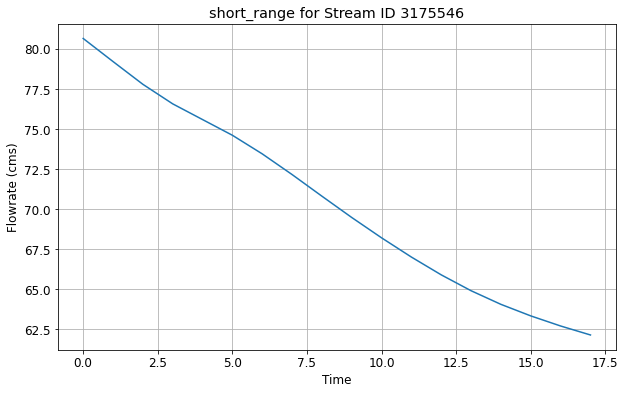

In [3]:
# This gets todays date, stores it in yyyymmdd format and assigns it to the variable 'today'
today = date.today()
today = str(today)
today = today.replace("-", "")

# Variable Notes
StreamID = 3175546                  # The unique identifier corresponding to a river segment
ForecastStartDate = today           # Today's date in YYYYMMDD format. 
ForecastStartTimestep = '00'        # Timestep forecast was issued, 00 = midnight CST
ForecastType = 'short_range'        # Options are 'short_range', 'medium_range', and 'long_range'
ForecastMember = '1'                # If using medium_range or 'long_range' then specify the ensemble member # (1-4 for long_range or 1-7 for medium_range)

#Now we use the GetSeries function from above, and provide it with the arguments as defined above.
Series = GetSeries(StreamID, ForecastStartDate, ForecastStartTimestep, ForecastType, ForecastMember)
print(Series)

# Draw a plot for the series
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title(ForecastType + ' for Stream ID ' + str(StreamID))
ax.grid(True)

#This cell could take a while to run! Be patient!
#medium_range for members 2-9 doesn't work...

The next cell erases the forecast files that were downloaded previously. You can see the files on the left hand side of your screen by clicking on the folder icon prior to running the cell. The cell is also written so that it will print the name of each file that it removes/deletes.

In [4]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Look at every file and if contains 'nwm' then remove/delete it! 
    if "nwm" in f:
        print(f)
        os.remove(f)

nwm.t00z.short_range.channel_rt.f004.conus.nc
nwm.t00z.short_range.channel_rt.f012.conus.nc
nwm.t00z.short_range.channel_rt.f010.conus.nc
nwm.t00z.short_range.channel_rt.f001.conus.nc
nwm.t00z.short_range.channel_rt.f016.conus.nc
nwm.t00z.short_range.channel_rt.f002.conus.nc
nwm.t00z.short_range.channel_rt.f011.conus.nc
nwm.t00z.short_range.channel_rt.f013.conus.nc
nwm.t00z.short_range.channel_rt.f006.conus.nc
nwm.t00z.short_range.channel_rt.f007.conus.nc
nwm.t00z.short_range.channel_rt.f005.conus.nc
nwm.t00z.short_range.channel_rt.f008.conus.nc
nwm.t00z.short_range.channel_rt.f015.conus.nc
nwm.t00z.short_range.channel_rt.f003.conus.nc
nwm.t00z.short_range.channel_rt.f009.conus.nc
nwm.t00z.short_range.channel_rt.f014.conus.nc
nwm.t00z.short_range.channel_rt.f017.conus.nc
nwm.t00z.short_range.channel_rt.f018.conus.nc


Now lets take a look at a few different rivers and their forecasts. Sometimes looking at forecasts for several rivers in an area might provide a better picture of what is going on. Let's take a look at forecasts for 3 rivers near Clarksville, TN.

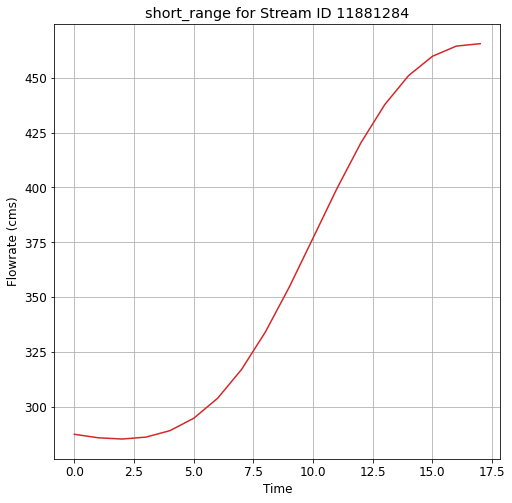

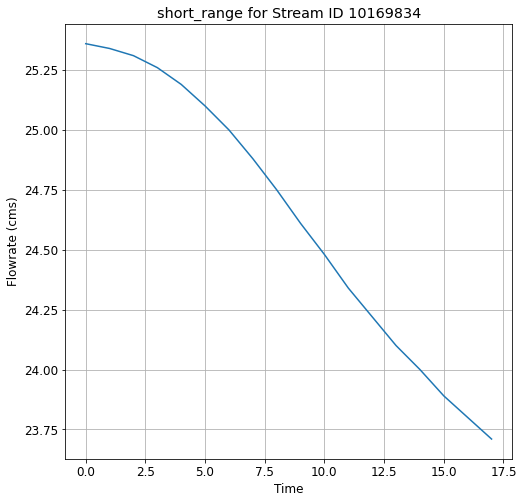

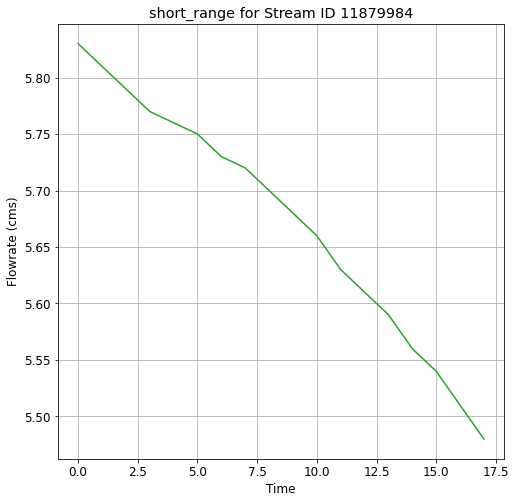

In [5]:
#Stream/Reach IDs
cumberland_river_id = 11881284
red_river_id = 10169834
little_river_id = 11879984

#Obtaining time series data
cumberland_series = GetSeries(cumberland_river_id, today, '00', 'short_range', '1')
red_series = GetSeries(red_river_id, today, '00', 'short_range', '1')
little_series = GetSeries(little_river_id, today, '00', 'short_range', '1')

#Cumberland River Plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(cumberland_series, color='tab:red', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(cumberland_river_id))
ax.grid(True)

#Red River Plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(red_series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(red_river_id))
ax.grid(True)

#Little River Plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(little_series, color='tab:green', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(little_river_id))
ax.grid(True)

Now let's plot all of those together.

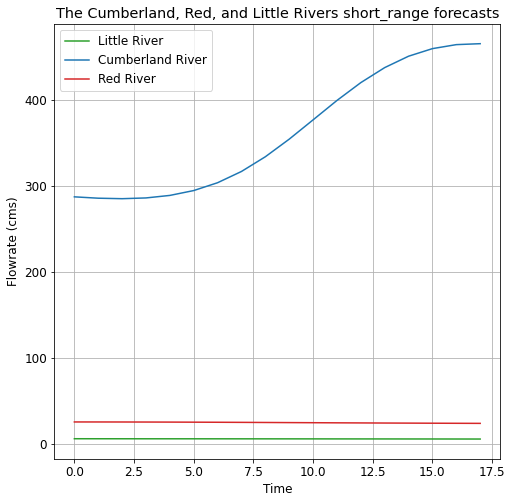

In [6]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(little_series, color='tab:green', label='Streamflow')
ax.plot(cumberland_series, color='tab:blue', label='Streamflow')
ax.plot(red_series, color='tab:red', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('The Cumberland, Red, and Little Rivers' + ' short_range forecasts')
plt.legend(["Little River", "Cumberland River", "Red River"])
ax.grid(True)

Because the Red River and the Little River have relatively small volumes as compared to the much larger Cumberland River, that plot isn't particularly useful. Let's try that again.

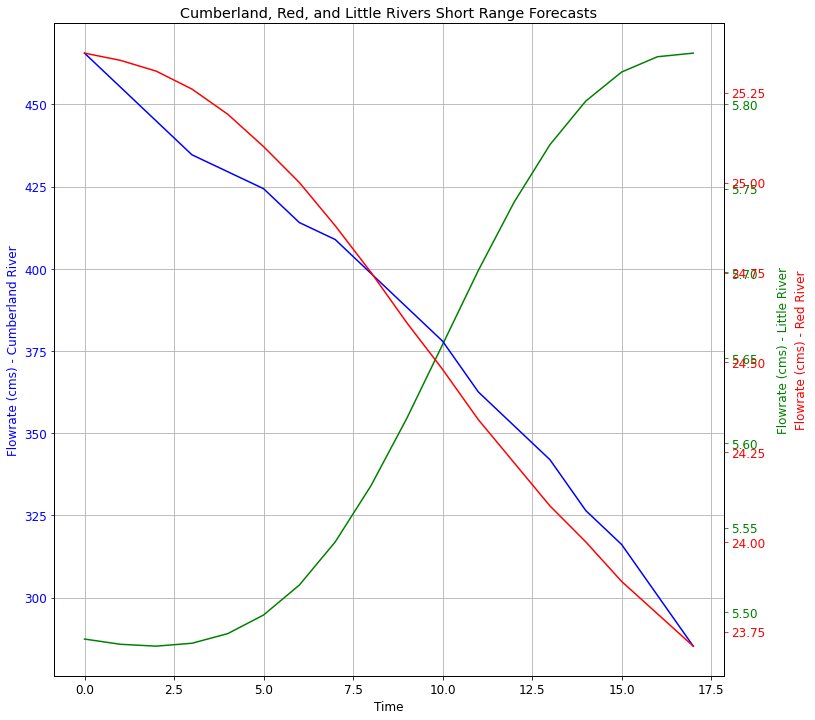

In [40]:
#Still working on this

s1 = cumberland_series
s2 = red_series
s3 = little_series

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(12, 12))

twin1 = ax.twinx()
twin2 = ax.twinx()

ax.plot(s1, "g-")
twin1.plot(s3, "b-")
twin2.plot(s2, "r-")

ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms) - Cumberland River')
twin1.set_ylabel("Flowrate (cms) - Little River", labelpad=20)
twin2.set_ylabel("Flowrate (cms) - Red River", labelpad=30)

ax.yaxis.label.set_color("blue")
twin1.yaxis.label.set_color("green")
twin2.yaxis.label.set_color("red")

ax.tick_params(axis='y', colors="blue")
twin1.tick_params(axis='y', colors="green")
twin2.tick_params(axis='y', colors="red")

ax.set_title('Cumberland, Red, and Little Rivers' + ' Short Range Forecasts')
ax.grid(True)